# Week 9-1: Unsupervised Machine Learning

## Bibliotheken importeren

In [18]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
import sqlite3
go_sales_connect = sqlite3.connect('go_sales.sqlite')

## Data inlezen en kolommen selecteren

In [3]:
df = pd.read_sql_query()
df

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Age,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,1,3,Braund; Mr. Owen Harris,male,1,0,A/5 21171,7.25,NaN,S,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,1,0,PC 17599,712.833,C85,C,...,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,Heikkinen; Miss. Laina,female,0,0,STON/O2. 3101282,7.925,NaN,S,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,1,0,113803,53.1,C123,S,...,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,Allen; Mr. William Henry,male,0,0,373450,8.05,NaN,S,...,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,Montvila; Rev. Juozas,male,0,0,211536,13,NaN,S,...,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,888,1,Graham; Miss. Margaret Edith,female,0,0,112053,30,B42,S,...,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,889,3,"Johnston; Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,NaN,S,...,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,890,1,Behr; Mr. Karl Howell,male,0,0,111369,30,C148,C,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[:, ['Pclass', 'Sex', 'Age', 'Survived']]
df

,Pclass,Sex,Age,Survived
0,3,male,22,0
1,1,female,38,1
2,3,female,26,1
3,1,female,35,1
4,3,male,35,0
...,...,...,...,...
886,2,male,27,0
887,1,female,19,1
888,3,female,15,0
889,1,male,26,1


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [5]:
df['Pclass'] = df['Pclass'].astype(str)
df.dtypes

Pclass      object
Sex         object
Age          int64
Survived     int64
dtype: object

In [6]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['Sex', 'Pclass']])
dummies_dataframe

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,True,False,False
4,False,True,False,False,True
...,...,...,...,...,...
886,False,True,False,True,False
887,True,False,True,False,False
888,True,False,False,False,True
889,False,True,True,False,False


In [7]:
df = pd.concat([df, dummies_dataframe], axis = 1)
df = df.drop(['Sex'], axis = 1)
df = df.loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age', 'Survived']]
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived
0,False,False,True,False,True,22,0
1,True,False,False,True,False,38,1
2,False,False,True,True,False,26,1
3,True,False,False,True,False,35,1
4,False,False,True,False,True,35,0
...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0
887,True,False,False,True,False,19,1
888,False,False,True,True,False,15,0
889,True,False,False,False,True,26,1


## Clusteringmodel bouwen met 2 dimensies

In [8]:
df_2d = df.loc[:, ['Age', 'Survived']]
df_2d

,Age,Survived
0,22,0
1,38,1
2,26,1
3,35,1
4,35,0
...,...,...
886,27,0
887,19,1
888,15,0
889,26,1


In [9]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1,
       2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 2, 0,
       1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1,
       1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2,

In [10]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,34.956186,0.384021
1,17.997093,0.380814
2,57.597484,0.389937


In [11]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,Age,Survived
0,34.956186,0.384021
1,17.997093,0.380814
2,57.597484,0.389937


In [12]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		22 - 34.95618556701033 = -12.95618556701033
		0 - 0.384020618556701 = -0.384020618556701
	Totale euclidische som: 168.01021628228344
	Euclidische afstand: 12.961875492469577
------------------------------------------------
	Centrumindex 1:
		22 - 17.997093023255815 = 4.002906976744185
		0 - 0.38081395348837205 = -0.38081395348837205
	Totale euclidische som: 16.16828353163872
	Euclidische afstand: 4.020980419206082
------------------------------------------------
	Centrumindex 2:
		22 - 57.59748427672954 = -35.59748427672954
		0 - 0.38993710691823896 = -0.38993710691823896
	Totale euclidische som: 1267.3329377793584
	Euclidische afstand: 35.59961991060239
------------------------------------------------
{0: 12.961875492469577, 1: 4.020980419206082, 2: 35.59961991060239}
1
Afstand van bronindex 1 tot...
	Centrumindex 0:
		38 - 34.95618556701033 = 3.04381443298967
		1 - 0.384020618556701 = 0.615979381443299
	Totale euclidische som: 9.64423

,Age,Survived,Centrum
0,22,0,1.0
1,38,1,0.0
2,26,1,1.0
3,35,1,0.0
4,35,0,0.0
...,...,...,...
886,27,0,0.0
887,19,1,1.0
888,15,0,1.0
889,26,1,1.0


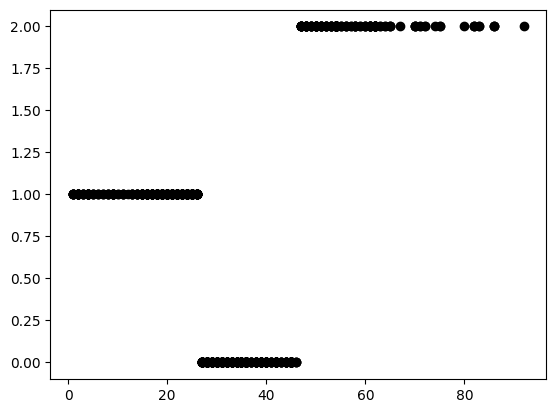

In [13]:
plt.scatter(df_2d['Age'], df_2d['Centrum'], color = 'k')
plt.show()

In [14]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,388
1,344
2,159


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [15]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([0, 4, 0, 2, 2, 2, 1, 3, 2, 0, 3, 1, 0, 4, 0, 1, 3, 2, 2, 2, 2, 2,
       0, 2, 3, 4, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 3, 0, 4, 2, 1, 2, 0, 2, 3, 3, 0, 4, 4, 3, 4, 4,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 4, 4, 5, 2, 0, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 4, 0, 1, 0, 5, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 4, 0,
       4, 0, 0, 0, 0, 0, 5, 2, 0, 3, 0, 5, 2, 2, 1, 3, 2, 0, 2, 4, 2, 0,
       4, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 4, 1, 0, 1, 4,
       0, 1, 0, 2, 0, 0, 4, 4, 0, 0, 3, 3, 0, 4, 0, 2, 1, 3, 3, 0, 1, 0,
       0, 1, 2, 2, 0, 0, 3, 3, 3, 0, 0, 4, 4, 2, 2, 0, 0, 3, 4, 1, 0, 4,
       0, 0, 2, 0, 2, 4, 0, 3, 2, 0, 0, 4, 0, 2, 0, 2, 4, 2, 2, 4, 2, 2,
       0, 2, 1, 4, 4, 0, 0, 0, 0, 2, 2, 2, 1, 3, 0, 2, 4, 3, 0, 2, 2, 2,
       2, 0, 2, 4, 0, 0, 2, 1, 2, 2, 1, 2, 4, 2, 2, 2, 2, 1, 2, 3, 1, 4,
       2, 2, 0, 0, 1, 2, 2, 0, 4, 2, 2, 1, 4, 2, 3, 2, 1, 2, 0, 0, 2, 2,
       2, 0, 4, 0, 0, 0, 2, 0, 0, 2, 0, 3, 1, 1, 1,

In [16]:
df['Centrum'] = prediction_results
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived,Centrum
0,False,False,True,False,True,22,0,0
1,True,False,False,True,False,38,1,4
2,False,False,True,True,False,26,1,0
3,True,False,False,True,False,35,1,2
4,False,False,True,False,True,35,0,2
...,...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0,2
887,True,False,False,True,False,19,1,0
888,False,False,True,True,False,15,0,0
889,True,False,False,False,True,26,1,0


### De juiste centra toewijzen aan rijen uit de dataset

In [17]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,278
1,113
2,267
3,66
4,145
5,22


## Evalueren